In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

2025-04-03 22:59:59.770080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743713999.863952  165848 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743713999.890223  165848 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743714000.126316  165848 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743714000.126380  165848 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743714000.126382  165848 computation_placer.cc:177] computation placer alr

## Fonctions

In [5]:
def load_dataset(up_to= None):
    '''
    Charge les fichiers DVF jusqu'à une année donnée (incluse).

    Paramètres:
        up_to (str): Année maximale à charger, ex: "2020", "2023".

    Return:
        DataFrame Pandas combiné sans doublons.
    '''

    data_files = {
        "2019": "data/ValeursFoncieres-2019-S2.txt",
        "2020": "data/ValeursFoncieres-2020.txt",
        "2021": "data/ValeursFoncieres-2021.txt",
        "2022": "data/ValeursFoncieres-2022.txt",
        "2023": "data/ValeursFoncieres-2023.txt",
        "2024": "data/ValeursFoncieres-2024-S1.txt",
    }

    valid_years = list(data_files.keys())
    if (up_to != None) & (up_to not in valid_years):
        print("Erreur: \"up_to\" doit être une année entre \"2019\" et \"2024\".")
        return -1

    data_list = []
    for year, path in data_files.items():
        print(f"Chargement {year}...")
        df = pd.read_csv(path, delimiter='|', dtype= str)
        data_list.append(df)
        # print("\n")
        if (up_to != None) & (year == up_to):
            break

    data = pd.concat(data_list, ignore_index=True)
    # data.drop_duplicates(inplace=True) #? Fait crash le kernel, désactivé pour le moment
    print(f"\n{len(data):,} lignes chargées au total.")
    return data

def parse_dataset(data, max=None, all_local_type= False):
    '''
    Parsing des données, on ne garde que les lignes des ventes et de certains types de local.
    Seule les colonnes suivantes sont gardées : "Valeur fonciere", "Date mutation", "Code departement", "Type local", "Surface terrain", "Surface reelle bati", "Nombre pieces principales".
    Les lignes comportant des NaN sont supprimées.
    Ajout de colonnes pour "Année", "Mois", "Jour".
    Valeurs de target plafonnée.
    
    Paramètres:
        data (DataFrame): strucutre d'un fichier DVF.
        max (float): valeur maximum de target.
        all_local_type (bool): définit si l'on exclu certains types de local ou non.

    Retour:
        DataFrames Pandas, X contenant les features et y contenant la target.
    '''

    data = data[(data["Nature mutation"] == "Vente")]

    if all_local_type == False:
        data = data[(data["Type local"] == "Maison") | (data["Type local"] == "Appartement")]

    data = data.dropna(subset=["Date mutation", "Valeur fonciere", "Code departement", "Type local", "Surface reelle bati", "Nombre pieces principales", "Surface terrain"])
    data["Valeur fonciere"] = data["Valeur fonciere"].str.replace(",", ".", regex= False).astype(float)

    if max:
        data = data[(data["Valeur fonciere"] < max)]

    data["Date mutation"] = pd.to_datetime(data["Date mutation"], format="%d/%m/%Y", errors="coerce")
    data["Année"] = data["Date mutation"].dt.year
    data["Mois"] = data["Date mutation"].dt.month
    data["Jour"] = data["Date mutation"].dt.day
    data["Surface reelle bati"] = data["Surface reelle bati"].str.replace(",", ".", regex= False).astype(float)
    data["Nombre pieces principales"] = data["Nombre pieces principales"].astype(int)
    data["Surface terrain"] = data["Surface terrain"].str.replace(",", ".", regex= False).astype(float)

    features = ["Date mutation", "Code departement", "Type local", "Surface terrain", "Surface reelle bati", "Nombre pieces principales", "Année", "Mois", "Jour"]
    target = "Valeur fonciere"
    X = data[features]
    y = data[target]
    return X, y

def split_dataset(X, y, test_size= .3):
    '''
    Normalise et classifie X et y puis split en sets d'entrainement et de test.

    Paramètres:
        X (DataFrame): DF contenant les features.
        y (DataFrame): DF contenant la target.
        test_size (float): % de X à envoyer dans X_test
    
    Retour:
        Données X et y split en 2 sets (train et test).
    '''

    categorical_features = ["Code departement", "Type local"]
    numeric_features = [ "Année", "Mois", "Jour", "Surface reelle bati", "Nombre pieces principales", "Surface terrain"]
    preprocessor = ColumnTransformer(transformers= [('num', StandardScaler(), numeric_features),('cat', OneHotEncoder(handle_unknown= 'ignore'), categorical_features)])
    X_processed = preprocessor.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size= test_size, random_state= 42)
    return X_train, X_test, y_train, y_test

def visualize_data(X, y):
    '''
    Affiche differents informations sur le dataset.
    
    Paramètres:
        X (DataFrame): DataFrame contenant les features.
        y (DataFrame): DataFrame contenant la target.
    
    Retour:
        None
    '''

#* Stats
#*********************************************************************#
    print("Shape des features:", X.shape)
    print("Colonnes:", X.columns.tolist())
    print("\nAperçu des données:")
    display(X.head())
    print("\nRésumé statistique des variables numériques:")
    display(X.describe())
    print("\nRépartition des types de biens:")
    print(X["Type local"].value_counts())

    X_copy = X.copy()
    X_copy["Valeur fonciere"] = y

    pivot = X_copy.pivot_table(
        values="Valeur fonciere",
        index="Code departement",
        columns="Type local",
        aggfunc="mean"
    ).fillna(0)

    mean_values_property_type = X_copy.groupby("Type local")["Valeur fonciere"].mean().sort_values()
    mean_values_departement = X_copy.groupby("Code departement")["Valeur fonciere"].mean().sort_values()
    numerical_features = ["Date mutation", "Surface terrain", "Surface reelle bati", "Nombre pieces principales"]
    corr_matrix = X_copy[numerical_features].corr()
    grouped = X_copy.groupby(["Année", "Mois"])["Valeur fonciere"]
    mean_time = grouped.agg(['mean', 'std']).reset_index()
    mean_time["Date"] = pd.to_datetime(mean_time["Année"].astype(str) + "-" + mean_time["Mois"].astype(str) + "-01")
    lower_err = np.minimum(mean_time["mean"], mean_time["std"])
    upper_err = mean_time["std"]
    yerr = [lower_err, upper_err]

#* Matrice de correlation
#*********************************************************************#
    plt.figure(figsize= (10, 6))
    plt.imshow(corr_matrix, cmap= "Reds")
    plt.xticks(ticks= np.arange(len(numerical_features)), labels=numerical_features, rotation= 45)
    plt.yticks(ticks= np.arange(len(numerical_features)), labels=numerical_features)
    plt.title("Matrice de corrélation")
    for i in range(len(numerical_features)):
        for j in range(len(numerical_features)):
            value = corr_matrix.iloc[i, j]
            plt.text(j, i, f"{value:.2f}", ha= "center", va= "center", color= "black")
    plt.tight_layout()
    plt.show()

#* Hist Valeur Fonciere
#*********************************************************************#
    plt.figure(figsize= (20, 3))
    plt.hist(y, bins= 100, color= "r", edgecolor='black')
    plt.title("Distribution de la valeur foncière")
    plt.xlabel("Valeur foncière (€)")
    plt.ylabel("Nombre de ventes")
    plt.grid(True, alpha= .4)
    plt.tight_layout()
    plt.show()

#* Hist type bien + departement
#*********************************************************************#
    plt.figure(figsize= (20, 8))

    plt.subplot(311)
    plt.bar(mean_values_property_type.index, mean_values_property_type.values, edgecolor= "black", color= "r", width= .1)
    plt.ylabel("Valeur foncière moyenne (€)")
    plt.title("Valeur foncière moyenne par type de bien")

    plt.subplot(312)
    plt.bar(mean_values_departement.index, mean_values_departement.values, edgecolor= "black", color= "r", width= .5)
    plt.xticks(rotation=45)
    plt.ylabel("Valeur foncière moyenne (€)")
    plt.title("Valeur foncière moyenne par département")
    plt.xlim(-1, 97)

    plt.subplot(313)
    plt.imshow(pivot.T, cmap='Reds', aspect= "auto")
    plt.colorbar(label="Valeur foncière moyenne (€)")
    plt.xticks(ticks= range(len(pivot.index)), labels= pivot.index, rotation= 45)
    plt.yticks(ticks= range(len(pivot.columns)), labels= pivot.columns)
    plt.title("Prix moyen par type de bien et département")
    plt.xlabel("Département")

    plt.tight_layout()
    plt.show()

#* Divers Valeurs Fonciere
#*********************************************************************#
    plt.figure(figsize= (20, 8))

    plt.subplot(311)
    plt.plot(mean_time["Date"], mean_time["mean"], color= "r", label= "Moyenne")
    plt.errorbar(mean_time["Date"], mean_time["mean"], yerr, ls= "", marker= ".", capsize= 2, color= "black", label= "Ecart-type")
    plt.title("Évolution du prix moyen des ventes dans le temps")
    plt.ylabel("Prix moyen (€)")
    plt.legend()
    plt.grid(True, alpha= .4)

    plt.subplot(312)
    plt.scatter(X_copy["Date mutation"], X_copy["Valeur fonciere"], s= 1, alpha= .1, color= 'r')
    plt.title("Valeur Foncière à différentes dates")
    plt.ylabel("Valeur Foncière (€)")
    plt.grid(True, alpha= .4)

    plt.subplot(313)
    plt.scatter(X_copy["Date mutation"], X_copy["Valeur fonciere"], s= 1, alpha= .2, marker= ".", color= "r")
    plt.ylabel("Valeur foncière (€)")
    plt.title("Valeurs foncière sur 10 jours")
    plt.xlim(pd.Timestamp("2019-07-07"), pd.Timestamp("2019-07-20"))

    plt.tight_layout()
    plt.show()

#* Divers Valeurs Fonciere (log)
#*********************************************************************#
    plt.figure(figsize= (20, 8))

    plt.subplot(311)
    plt.yscale("log")
    plt.plot(mean_time["Date"], mean_time["mean"], color= "r", label= "Moyenne")
    # plt.errorbar(mean_time["Date"], mean_time["mean"], yerr, ls= "", marker= ".", capsize= 2, color= "black", label= "Ecart-type")
    plt.title("Évolution du prix moyen des ventes dans le temps (echelle log)")
    plt.ylabel("Prix moyen (€)")
    # plt.legend()
    plt.grid(True, alpha= .4)

    plt.subplot(312)
    plt.yscale("log")
    plt.scatter(X_copy["Date mutation"], X_copy["Valeur fonciere"], s= 1, alpha= .1, color= 'r')
    plt.title("Valeur Foncière à différentes dates (echelle log)")
    plt.ylabel("Valeur Foncière (€)")
    plt.grid(True, alpha= .4)

    plt.subplot(313)
    plt.yscale("log")
    plt.scatter(X_copy["Date mutation"], X_copy["Valeur fonciere"], s= 1, alpha= .2, marker= ".", color= "r")
    plt.ylabel("Valeur foncière (€)")
    plt.title("Valeurs foncière sur 10 jours (echelle log)")
    plt.xlim(pd.Timestamp("2019-07-07"), pd.Timestamp("2019-07-20"))

    plt.tight_layout()
    plt.show()

## Importation des fichiers

In [6]:
data = load_dataset(up_to= "2021") #TODO crash toujour lorsque load au dessus de 2021

Chargement 2019...
Chargement 2020...
Chargement 2021...

10,162,527 lignes chargées au total.


## Parsing et visualisation des données

- Dataset complet :

Shape des features: (2194928, 9)
Colonnes: ['Date mutation', 'Code departement', 'Type local', 'Surface terrain', 'Surface reelle bati', 'Nombre pieces principales', 'Année', 'Mois', 'Jour']

Aperçu des données:


,Date mutation,Code departement,Type local,Surface terrain,Surface reelle bati,Nombre pieces principales,Année,Mois,Jour
0,2019-07-01,01,Maison,695.0,150.0,5,2019,7,1
1,2019-07-04,01,Maison,888.0,94.0,4,2019,7,4
2,2019-07-04,01,Maison,500.0,94.0,4,2019,7,4
3,2019-07-04,01,Maison,522.0,90.0,3,2019,7,4
5,2019-07-03,01,Maison,2483.0,110.0,5,2019,7,3



Résumé statistique des variables numériques:


,Date mutation,Surface terrain,Surface reelle bati,Nombre pieces principales,Année,Mois,Jour
count,2194928,2.194928e+06,2.194928e+06,2.194928e+06,2.194928e+06,2.194928e+06,2.194928e+06
mean,2020-10-20 22:12:41.985086976,1.174292e+03,9.697864e+01,3.968067e+00,2.020219e+03,7.505897e+00,1.700634e+01
min,2019-07-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,2.019000e+03,1.000000e+00,1.000000e+00
25%,2020-02-17 00:00:00,2.670000e+02,6.600000e+01,3.000000e+00,2.020000e+03,5.000000e+00,9.000000e+00
50%,2020-11-09 00:00:00,5.020000e+02,9.000000e+01,4.000000e+00,2.020000e+03,8.000000e+00,1.700000e+01
75%,2021-06-22 00:00:00,9.310000e+02,1.200000e+02,5.000000e+00,2.021000e+03,1.000000e+01,2.500000e+01
max,2021-12-31 00:00:00,2.448310e+06,1.640000e+03,1.090000e+02,2.021000e+03,1.200000e+01,3.100000e+01
std,NaN,5.770341e+03,4.975831e+01,1.648232e+00,7.678421e-01,3.309835e+00,8.981391e+00



Répartition des types de biens:
Type local
Maison         1830222
Appartement     364706
Name: count, dtype: int64


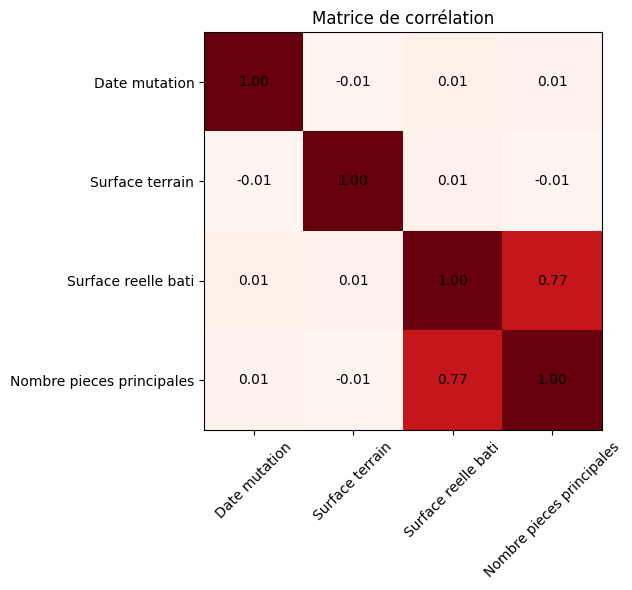

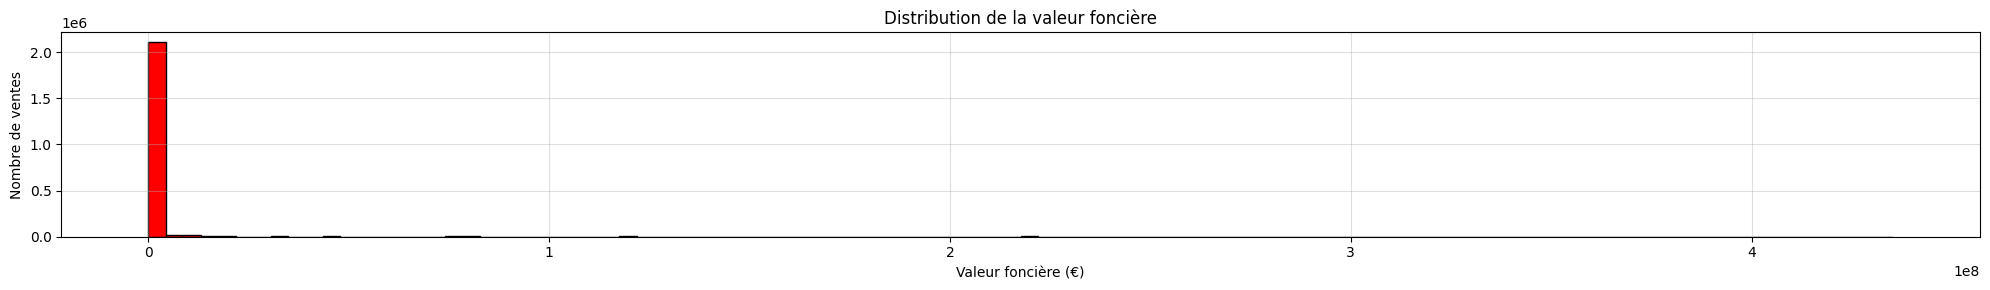

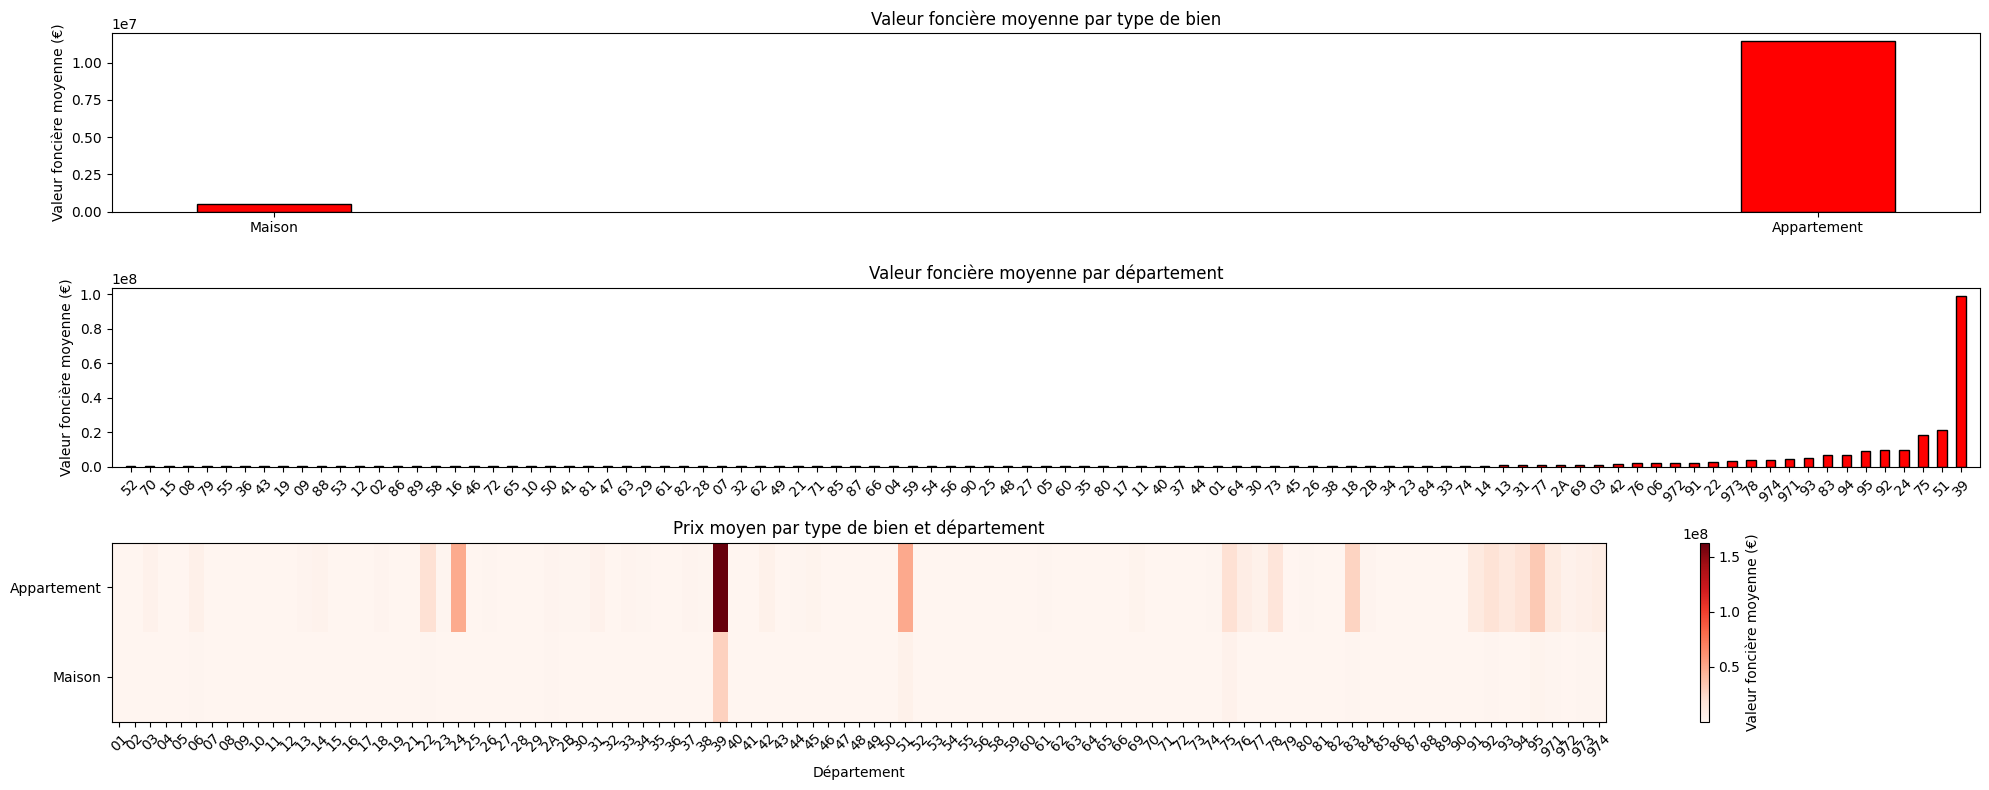

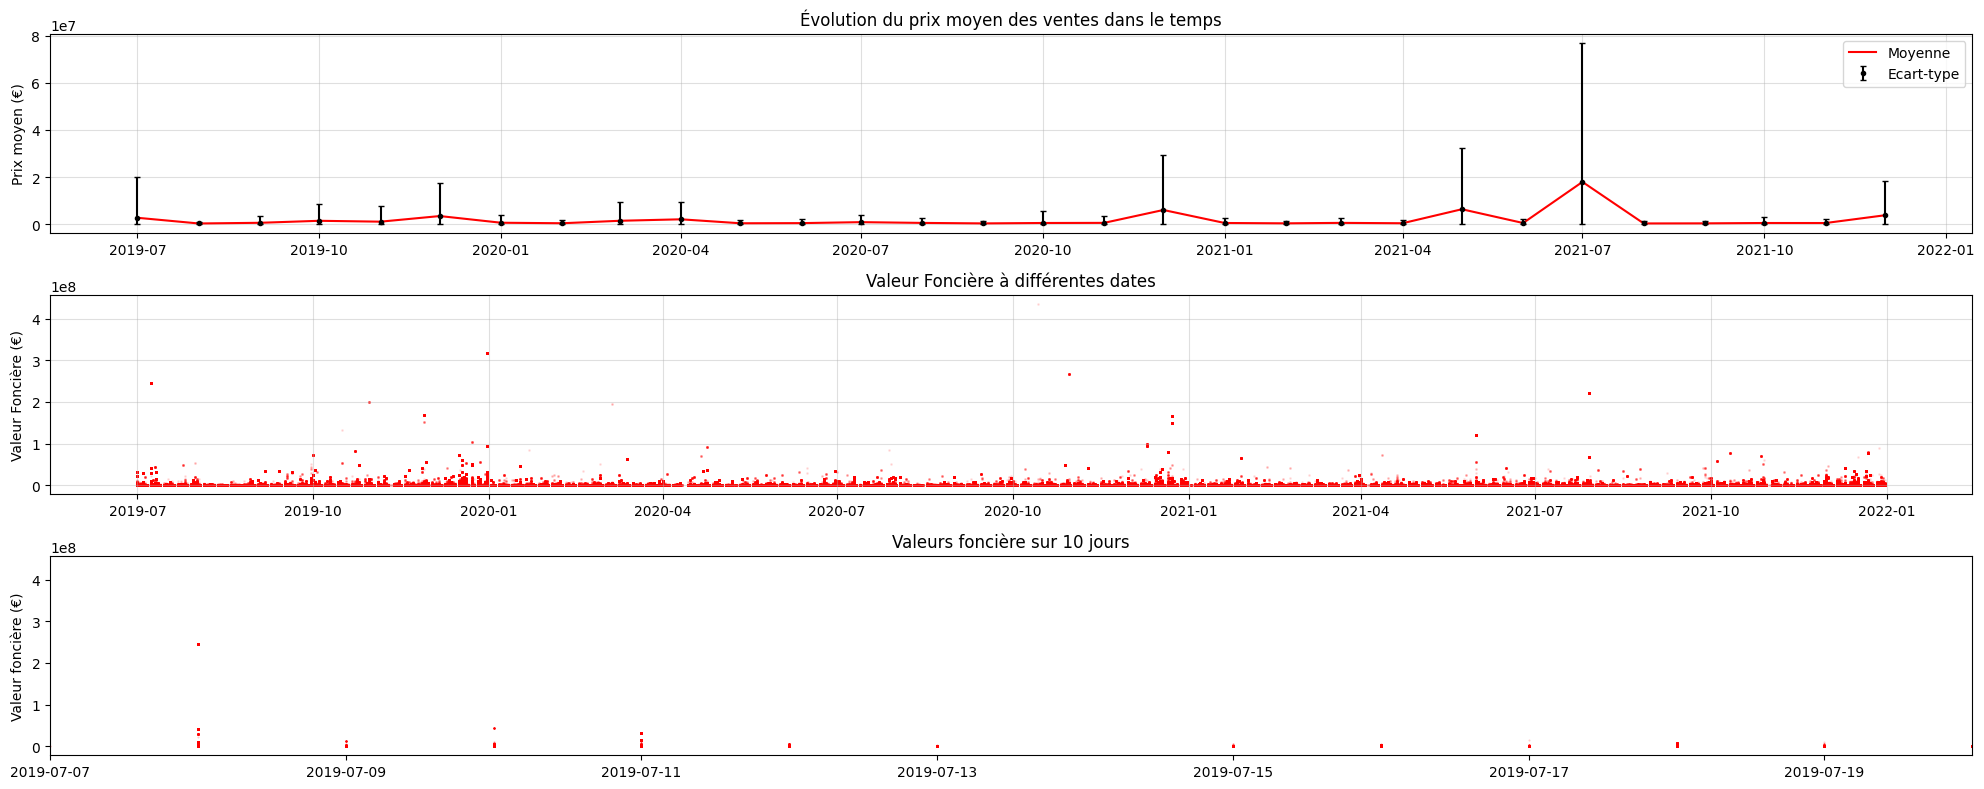

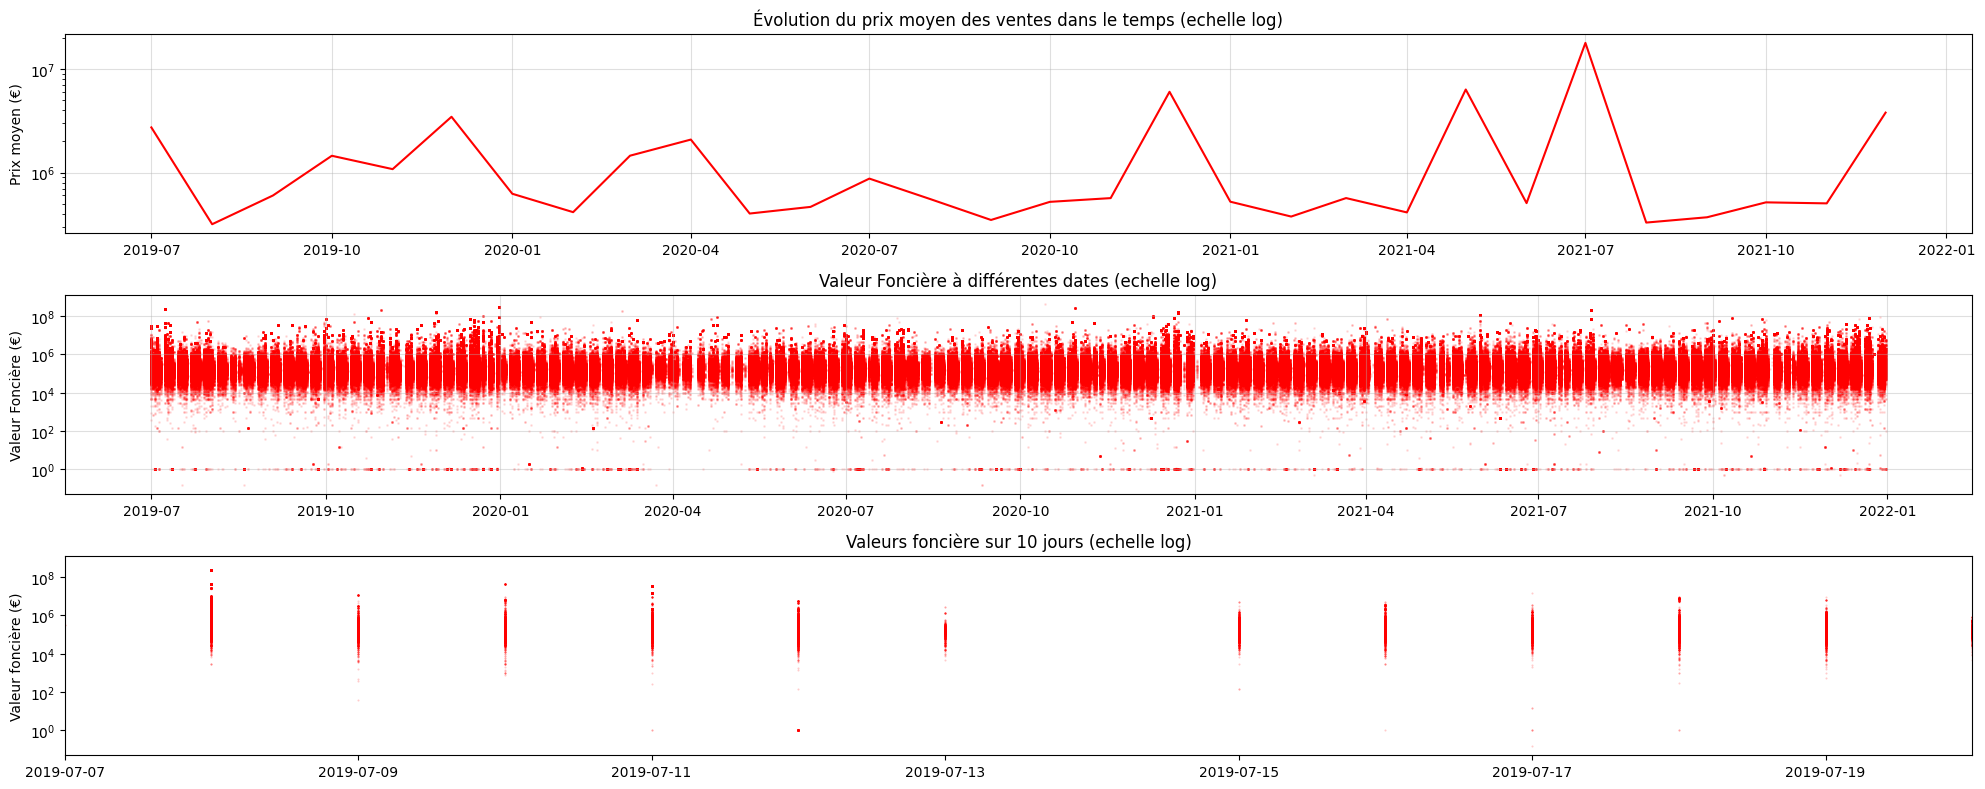

In [7]:
X, y = parse_dataset(data)
visualize_data(X, y)

- Dataset tronqué (en valeur foncière et en type de bien) :

Shape des features: (2068258, 9)
Colonnes: ['Date mutation', 'Code departement', 'Type local', 'Surface terrain', 'Surface reelle bati', 'Nombre pieces principales', 'Année', 'Mois', 'Jour']

Aperçu des données:


,Date mutation,Code departement,Type local,Surface terrain,Surface reelle bati,Nombre pieces principales,Année,Mois,Jour
0,2019-07-01,01,Maison,695.0,150.0,5,2019,7,1
1,2019-07-04,01,Maison,888.0,94.0,4,2019,7,4
2,2019-07-04,01,Maison,500.0,94.0,4,2019,7,4
3,2019-07-04,01,Maison,522.0,90.0,3,2019,7,4
5,2019-07-03,01,Maison,2483.0,110.0,5,2019,7,3



Résumé statistique des variables numériques:


,Date mutation,Surface terrain,Surface reelle bati,Nombre pieces principales,Année,Mois,Jour
count,2068258,2.068258e+06,2.068258e+06,2.068258e+06,2.068258e+06,2.068258e+06,2.068258e+06
mean,2020-10-21 00:30:09.620269312,8.981373e+02,9.829627e+01,4.017681e+00,2.020225e+03,7.447130e+00,1.686232e+01
min,2019-07-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,2.019000e+03,1.000000e+00,1.000000e+00
25%,2020-02-20 00:00:00,2.570000e+02,6.800000e+01,3.000000e+00,2.020000e+03,5.000000e+00,9.000000e+00
50%,2020-11-06 00:00:00,5.000000e+02,9.100000e+01,4.000000e+00,2.020000e+03,8.000000e+00,1.700000e+01
75%,2021-06-18 00:00:00,8.600000e+02,1.200000e+02,5.000000e+00,2.021000e+03,1.000000e+01,2.500000e+01
max,2021-12-31 00:00:00,7.987260e+05,1.640000e+03,1.090000e+02,2.021000e+03,1.200000e+01,3.100000e+01
std,NaN,3.722866e+03,4.809305e+01,1.624351e+00,7.639781e-01,3.300885e+00,8.951836e+00



Répartition des types de biens:
Type local
Maison         1806325
Appartement     261933
Name: count, dtype: int64


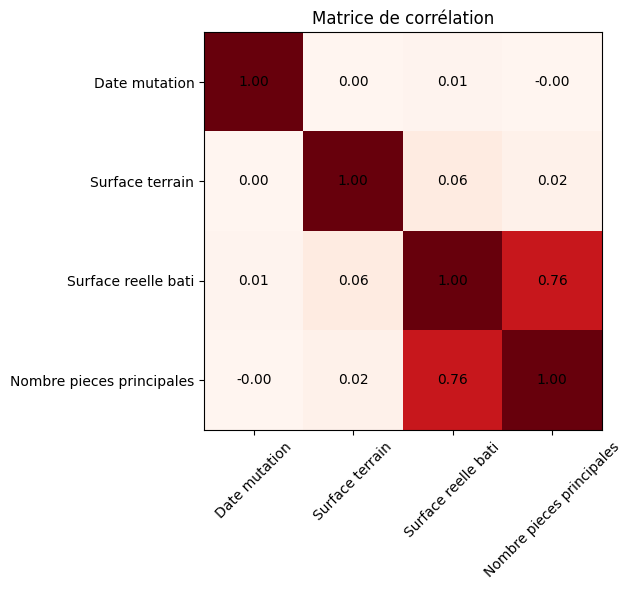

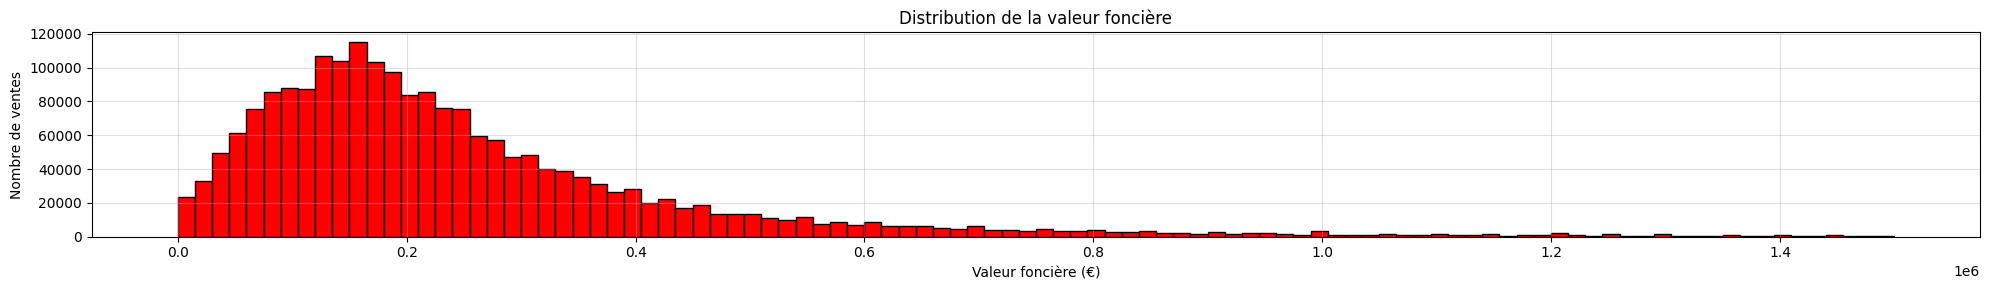

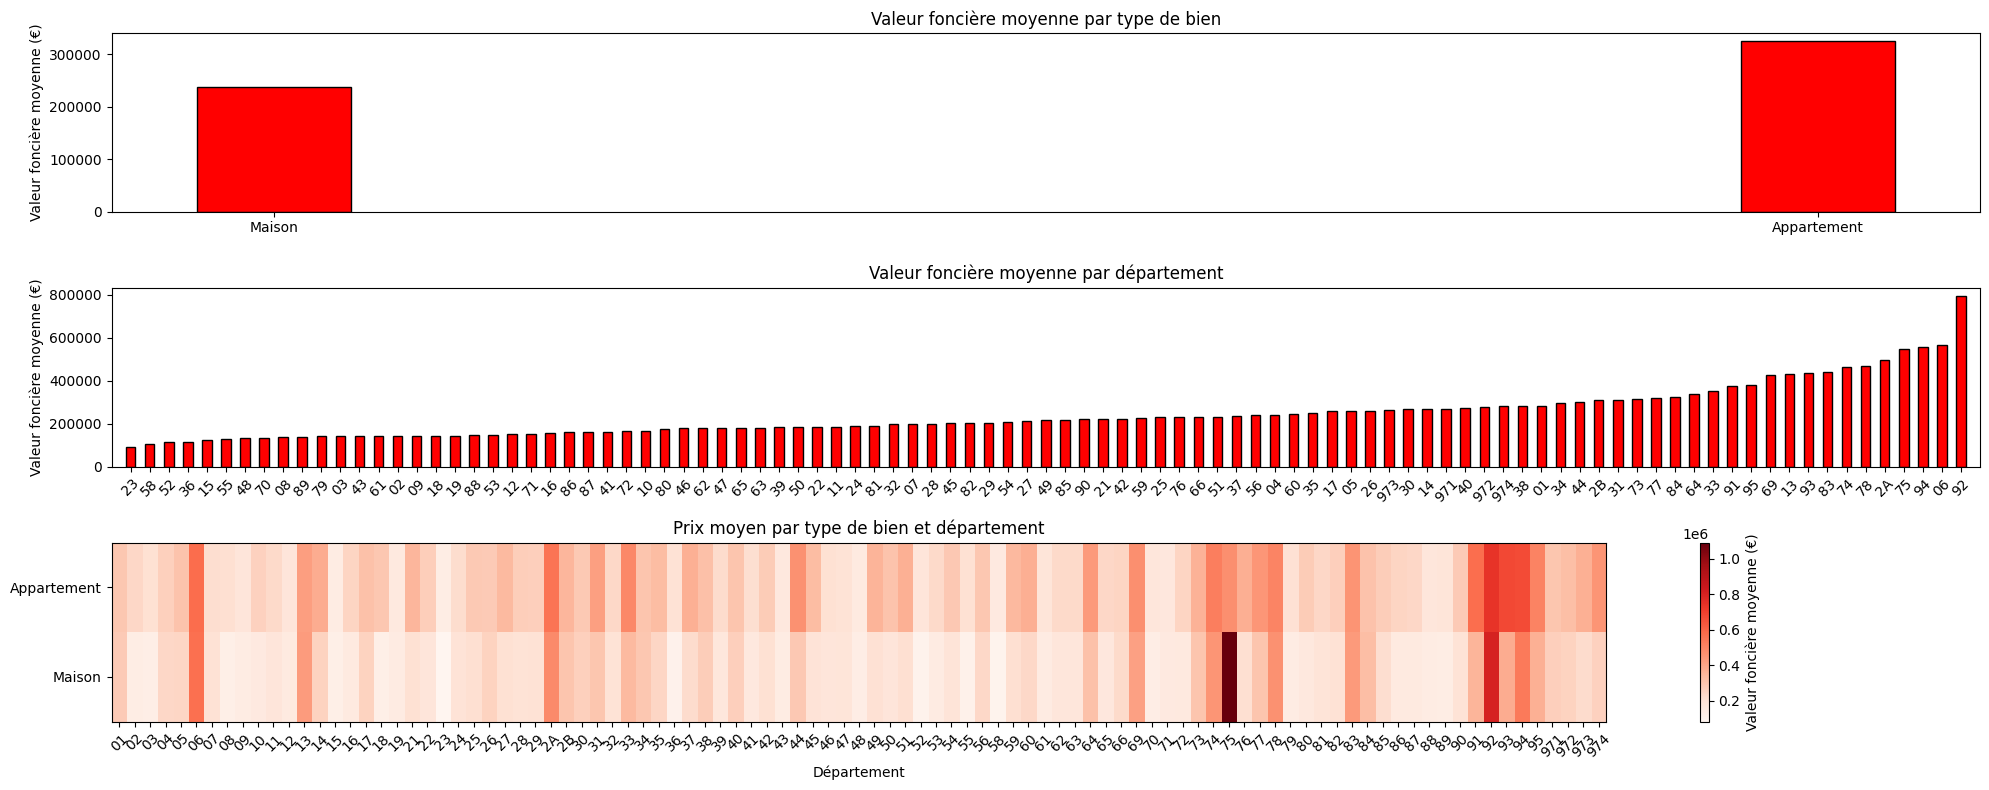

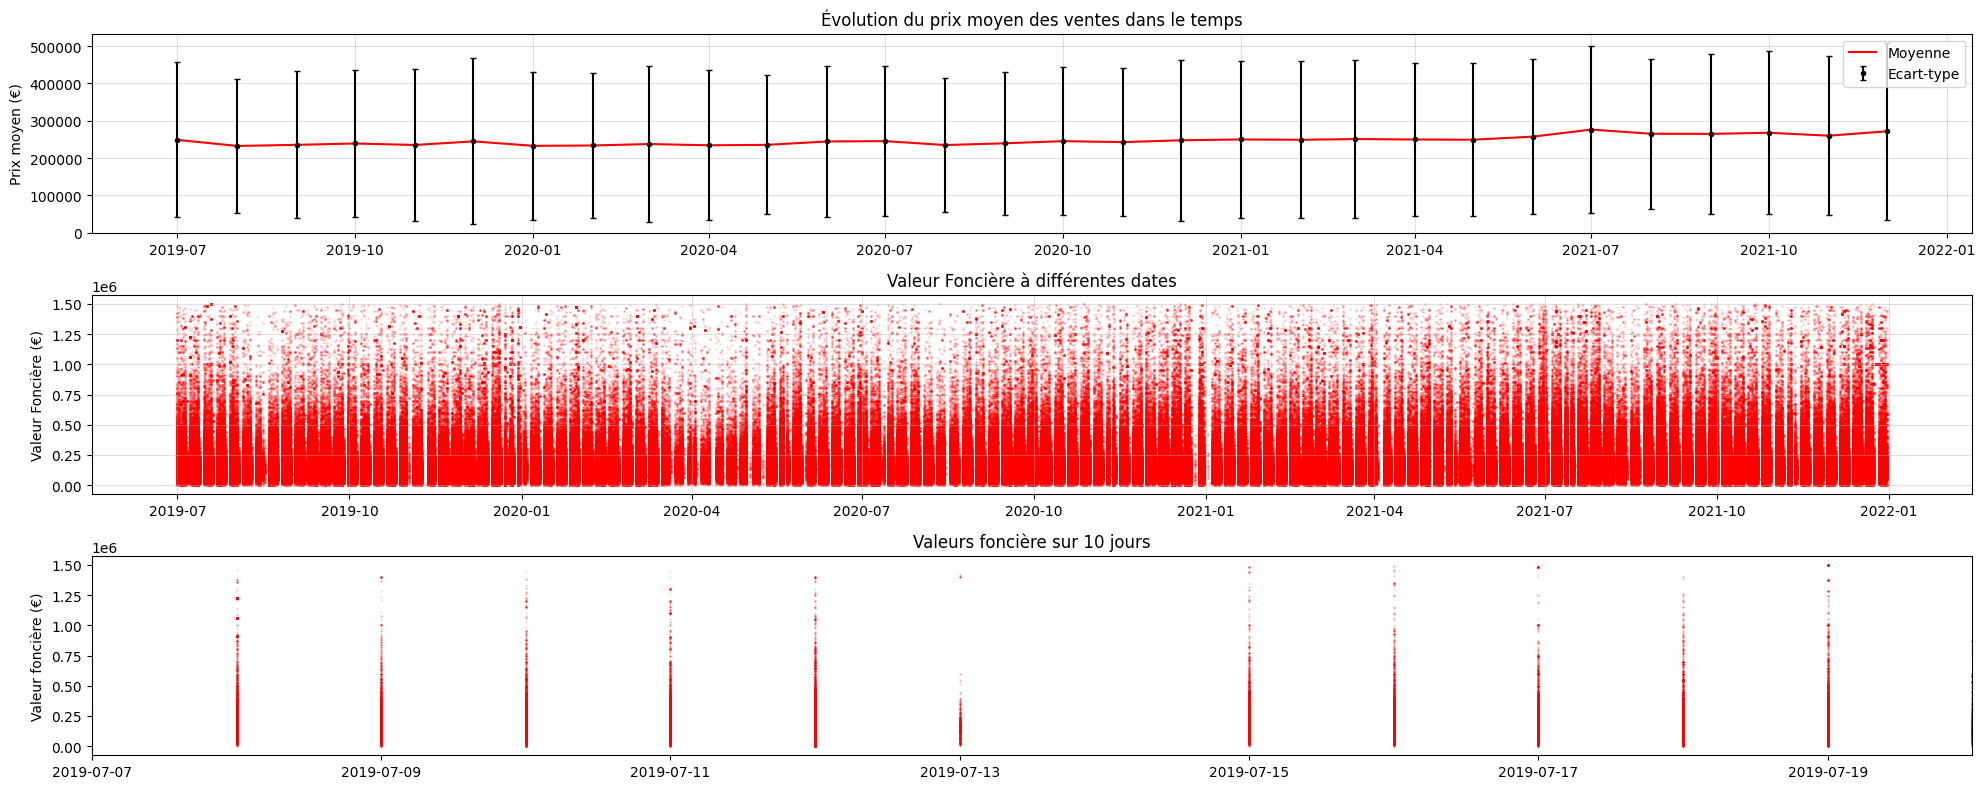

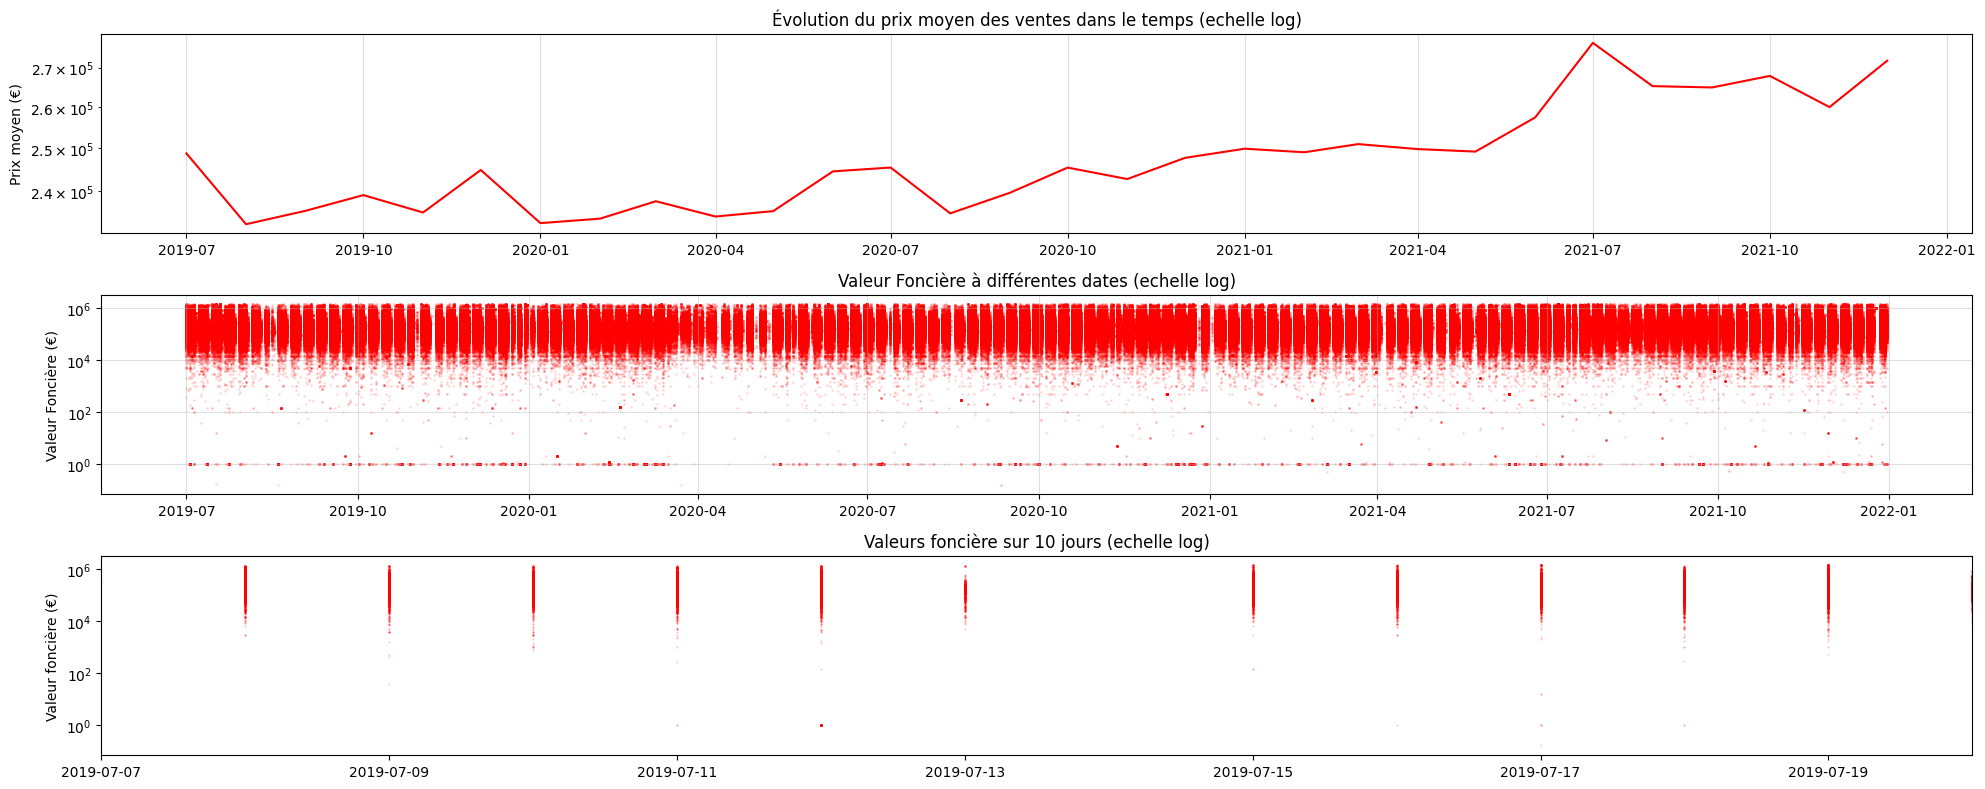

In [8]:
X_trunc, y_trunc = parse_dataset(data, max= 1500000)
visualize_data(X_trunc, y_trunc)

### Neural Network & models

In [9]:
# k = 16
# model = Sequential()
# model.add(Dense(128, activation= 'relu', input_dim= (X_train.shape[1])))
# model.add(Dense(64, activation= 'relu'))
# model.add(Dense(1))
# model.summary()

# model.compile(optimizer= Adam(learning_rate= 0.1 * k), loss= "mse", metrics=['acc'])

In [10]:
# # batch_size = X_train.shape[0] * 8 #* Attention uniquement pour travailler sur la 3090 sinon pas asser de mémoire/damage to memory
# batch_size = 256
# history = model.fit(X_train, y_train,
#     batch_size=         batch_size,
#     epochs=             100,
#     validation_split=   0.3,
#     verbose=            1)
# # ev = model.evaluate(X_test, y_test)
# # print(ev)

# plt.figure()
# plt.plot(history.history['loss'], label='training')
# plt.plot(history.history['val_loss'], label='validation')
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.yscale('log')
# plt.legend()
# plt.show()